In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Set path to input cleaned csv and ouput csv with feature created
path_in  = "hotel_bookings_cleaned.csv"                 
path_out = "hotel_bookings_credit_score.csv"

## Feature: `cxl_risk_score` — Rule-Based Cancellation Risk (0–100)

**Goal.** Turn raw booking fields into a single, interpretable cancellation-risk score to guide pricing, overbooking buffers, and inventory allocation.

### Components and formula
Four intuitive drivers are each min-max normalised to [0,1], then combined as a weighted sum × 100:
1. **Lead time** — longer lead times tend to cancel more (More time to reconsider about booking).
2. **Off-season flag** — bookings in defined off-season months are riskier (Lower demand for room).
3. **Single-party flag** — `adults == 1` and `children == babies == 0` (Lower commitment if travelling alone).
4. **Market historical cancel rate** — average `is_canceled` by `market_segment` (Historical behavior).

**Conceptual formula**
$$
\text{cxl_risk_score}= \big(
w_1 \cdot \text{minmax(lead_time)} +
w_2 \cdot \text{minmax(off_season_flag)} +
w_3 \cdot \text{minmax(single_party_flag)} +
w_4 \cdot \text{minmax(market_cxl_rate)}
\big)  \div \text{sum(}w_i{)} \times 100
$$

### Choosing `off_season_months`
- **Business rationale:** Lower demand often drive higher cancellation/no-show rates.
- **Assumption for this project:** Top 3 months with the fewest records `{January, November, December}`.

### Setting the weights
- `lead_time`: **0.25** ( driver)
- `market_hist`: **0.25** (segment behaviour)
- `off_season`: **0.25** (seasonality)
- `single_party`: **0.25** (commitment proxy)

**Why equal weights?**  
- Keeps the method transparent and defensible without modelling.  
- Avoids over-emphasising any single driver when business priors are uncertain.  
- Supports sensitivity checks later (swap to custom weights if management prefers or more assumption applied).

### Interpreting the score
- **0–20:** Very low risk — short lead time, in-season, families/parties, low-risk segment
- **20–50:** Low–moderate risk — monitor; modest overbooking buffer acceptable
- **50–80:** Elevated risk — consider deposits/prepayment or tighter allocation
- **80–100:** High risk — strong chance of cancellation; use stricter terms or larger buffer

In [78]:
import pandas as pd
import numpy as np

### ------------------ Config Dictionary------------------ ###
CFG = {
    "weights": {                 
        "lead_time":    0.25,
        "off_season":   0.25,
        "single_party": 0.25,
        "market_hist":  0.25,
    },
    "off_season_top_k": 3,       # <- pick the K least frequent months
}

### ------------------ Min-max normalisation ------------------ ###
def _minmax(x: pd.Series) -> pd.Series:
    """
    Min-Max Normalization function for drivers
    """
    x = pd.to_numeric(x)
    xmin, xmax = x.min(), x.max()
    if pd.isna(xmin) or pd.isna(xmax) or xmax == xmin:
        return pd.Series(np.zeros(len(x)), index=x.index) # return to zero if min = max or NaN for min/max
    return (x - xmin) / (xmax - xmin)

def det_off_season_months(df: pd.DataFrame, k: int) -> set:
    """
    Pick the K months with the fewest records as off-season months.
    Ties are handled by standard sort order; if fewer than K months exist, use all available.
    """
    months = df['arrival_date_month']

    counts = months.value_counts(dropna=True)  # counts by month
    counts = counts.sort_values(ascending=True) # ensure month order is by ascending frequency, then alphabetically for tie-break
    chosen = counts.index[:max(0, min(k, len(counts)))]
    print('Off-season months defined by demand: ',list(chosen))
    return set(chosen)

### ------------------ Main feature builder ------------------ ###
def add_cxl_risk_score(df: pd.DataFrame, cfg: dict = CFG) -> pd.DataFrame:
    """
    Create rule-based cancellation risk score in [0,100] using:
      - lead_time            (minmax normalisation)
      - off_season_flag      (1 if month in the K least frequent months)
      - single_party_flag    (1 adult, no children/babies)
      - market_cxl_rate      (mean of is_canceled by market_segment)
    """
    
    w = cfg["weights"]

    ### --- derive off-season months dynamically --- ###
    off_months = det_off_season_months(df, cfg.get("off_season_top_k", 3))
    off_season_flag = df['arrival_date_month'].isin(off_months).astype(int)

    ### --- single party flag --- ###
    single_party_flag = ((df['adults'].fillna(0) == 1) & (df['children'].fillna(0) == 0) & \
                         (df['babies'].fillna(0) == 0)).astype(int)

    ### --- market historical cancel rate --- ###
    market_rate = df.groupby('market_segment')['is_canceled'].mean().rename('market_cxl_rate')
    if 'Undefined' in market_rate.index: 
        market_rate.loc['Undefined'] = 1.0 # If `market_segment` is 'Undefined', default `market_cxl_rate = 1`
    df = df.merge(market_rate, on='market_segment', how="left")
 
    comp_list = []
    ### --- components --- ###
    comp_lead   = _minmax(df['lead_time']).fillna(1) # If `lead_time` is missing, default `comp_lead = 1`
    comp_off    = _minmax(off_season_flag).fillna(1) # If `arrival_date_month` is missing, default `comp_off = 1`
    comp_single = _minmax(single_party_flag).fillna(1) # If `single_party_flag` is missing, default `comp_single = 1
    comp_hist   = _minmax(df["market_cxl_rate"]).fillna(1) # If `market_segment` is missing, default `comp_hist = 1`

    ### --- weighted sum --- ###
    wsum = sum(abs(x) for x in w.values()) or 1.0
    df["cxl_risk_score"] = (
        w["lead_time"]    * comp_lead +
        w["off_season"]   * comp_off +
        w["single_party"] * comp_single +
        w["market_hist"]  * comp_hist
    ) / wsum * 100.0 # Restrict final score to [0,100]
    
    df["off_season_flag"] = off_season_flag  # For off-season months validation 
    
    return df

### ------------------ Output ------------------ ###
df = pd.read_csv(path_in)
df2 = add_cxl_risk_score(df, CFG)
df2["cxl_risk_score"].describe()

Off-season months defined by demand:  ['January', 'November', 'December']


count    87396.000000
mean        15.920520
std         13.530500
min          0.000000
25%          6.949031
50%          9.968027
75%         25.950459
max         73.439074
Name: cxl_risk_score, dtype: float64

In [79]:
# Save
df2.to_csv(path_out, index=False)

In [61]:
# df2[["arrival_date_month","off_season_flag","cxl_risk_score"]].head()

,arrival_date_month,off_season_flag,cxl_risk_score
0,July,0,12.342648
1,July,0,25.741562
2,July,0,25.979012
3,July,0,25.440977
4,July,0,7.084716


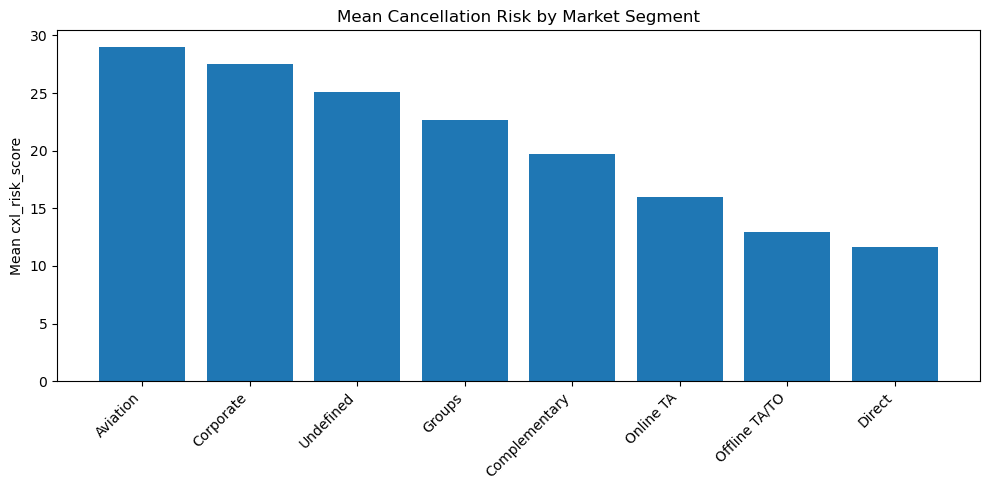

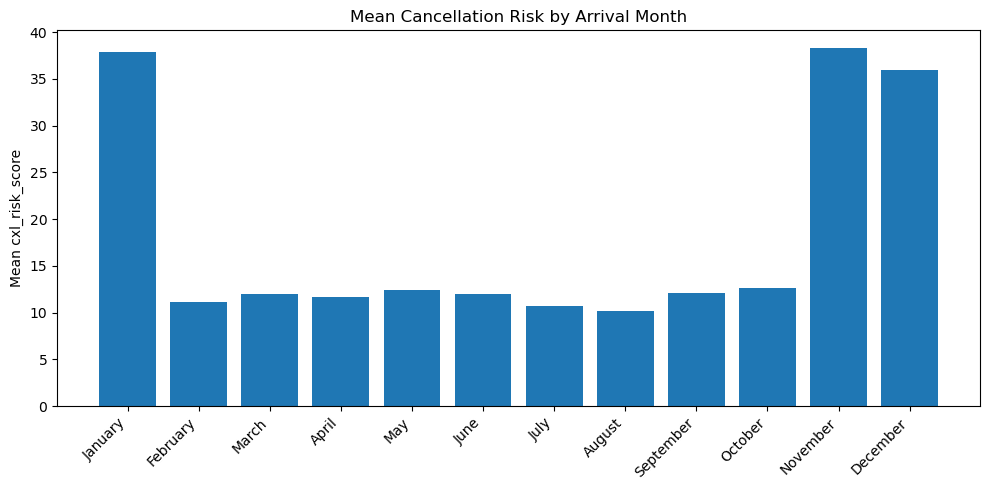

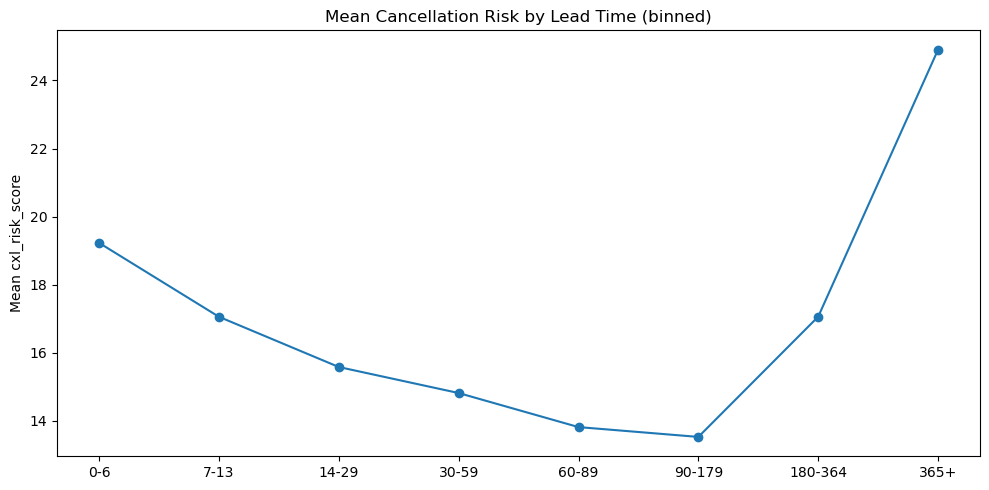

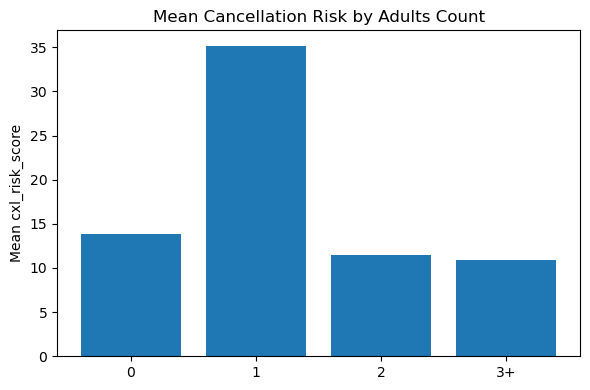

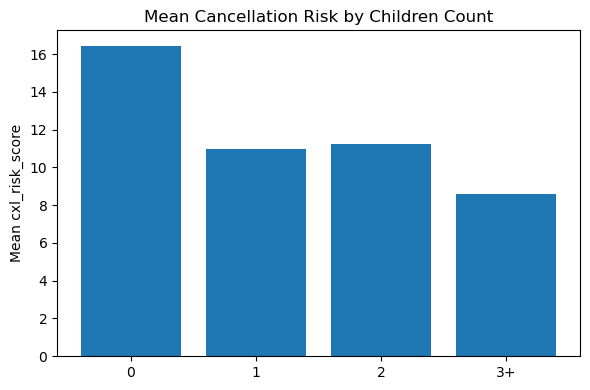

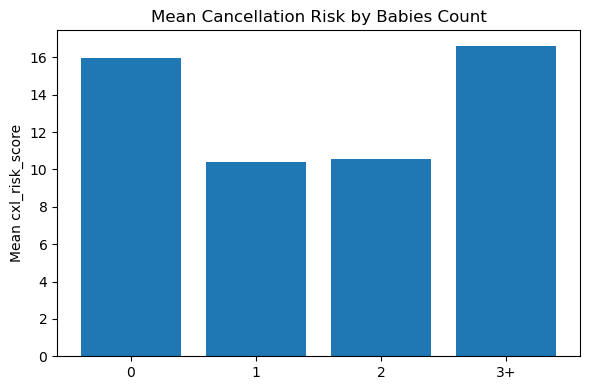

In [76]:


# ----------------- Plot helpers -----------------
def _sorted_months_index(s):
    order = ["January","February","March","April","May","June","July",
             "August","September","October","November","December"]
    s = s.astype(str)
    counts = s.value_counts()
    return [m for m in order if m in counts.index]

# 1) Mean cxl_risk_score by market_segment
if "market_segment" in df2.columns and "cxl_risk_score" in df2.columns:
    g = df2.groupby("market_segment")["cxl_risk_score"].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    plt.bar(g.index.astype(str), g.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean cxl_risk_score")
    plt.title("Mean Cancellation Risk by Market Segment")
    plt.tight_layout()
    plt.show()

# 2) Mean cxl_risk_score by arrival_date_month
if "arrival_date_month" in df2.columns and "cxl_risk_score" in df2.columns:
    g = df2.groupby("arrival_date_month")["cxl_risk_score"].mean()
    idx = _sorted_months_index(df2["arrival_date_month"])
    g = g.reindex(idx)
    plt.figure(figsize=(10,5))
    plt.bar(g.index.astype(str), g.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean cxl_risk_score")
    plt.title("Mean Cancellation Risk by Arrival Month")
    plt.tight_layout()
    plt.show()

# 3) Mean cxl_risk_score by lead_time bins
if "lead_time" in df2.columns and "cxl_risk_score" in df2.columns:
    bins = [0,7,14,30,60,90,180,365,9999]
    labels = ["0-6","7-13","14-29","30-59","60-89","90-179","180-364","365+"]
    lt = pd.to_numeric(df2["lead_time"], errors="coerce").fillna(0)
    df2["_lead_bin"] = pd.cut(lt, bins=bins, labels=labels, right=False, include_lowest=True)
    g = df2.groupby("_lead_bin")["cxl_risk_score"].mean()
    plt.figure(figsize=(10,5))
    plt.plot(g.index.astype(str), g.values, marker="o")
    plt.xticks(rotation=0)
    plt.ylabel("Mean cxl_risk_score")
    plt.title("Mean Cancellation Risk by Lead Time (binned)")
    plt.tight_layout()
    plt.show()
    df2.drop(columns=["_lead_bin"], errors="ignore", inplace=True)

# 4a) Mean cxl_risk_score by number of adults (0,1,2,3+)
if "adults" in df2.columns and "cxl_risk_score" in df2.columns:
    adults = pd.to_numeric(df2["adults"], errors="coerce").fillna(0).clip(upper=3)
    adults = adults.replace(3, np.nan)
    df2["_adults_bucket"] = adults.astype("Int64").astype(str).replace({"<NA>":"3+"})
    g = df2.groupby("_adults_bucket")["cxl_risk_score"].mean().reindex(["0","1","2","3+"])
    plt.figure(figsize=(6,4))
    plt.bar(g.index.astype(str), g.values)
    plt.ylabel("Mean cxl_risk_score")
    plt.title("Mean Cancellation Risk by Adults Count")
    plt.tight_layout()
    plt.show()
    df2.drop(columns=["_adults_bucket"], errors="ignore", inplace=True)

# 4b) Mean cxl_risk_score by number of children (0,1,2,3+)
if "children" in df2.columns and "cxl_risk_score" in df2.columns:
    children = pd.to_numeric(df2["children"], errors="coerce").fillna(0).clip(upper=3)
    children = children.replace(3, np.nan)
    df2["_children_bucket"] = children.astype("Int64").astype(str).replace({"<NA>":"3+"})
    g = df2.groupby("_children_bucket")["cxl_risk_score"].mean().reindex(["0","1","2","3+"])
    plt.figure(figsize=(6,4))
    plt.bar(g.index.astype(str), g.values)
    plt.ylabel("Mean cxl_risk_score")
    plt.title("Mean Cancellation Risk by Children Count")
    plt.tight_layout()
    plt.show()
    df2.drop(columns=["_children_bucket"], errors="ignore", inplace=True)

# 4c) Mean cxl_risk_score by number of babies (0,1,2,3+)
if "babies" in df2.columns and "cxl_risk_score" in df2.columns:
    babies = pd.to_numeric(df2["babies"], errors="coerce").fillna(0).clip(upper=3)
    babies = babies.replace(3, np.nan)
    df2["_babies_bucket"] = babies.astype("Int64").astype(str).replace({"<NA>":"3+"})
    g = df2.groupby("_babies_bucket")["cxl_risk_score"].mean().reindex(["0","1","2","3+"])
    plt.figure(figsize=(6,4))
    plt.bar(g.index.astype(str), g.values)
    plt.ylabel("Mean cxl_risk_score")
    plt.title("Mean Cancellation Risk by Babies Count")
    plt.tight_layout()
    plt.show()
    df2.drop(columns=["_babies_bucket"], errors="ignore", inplace=True)
